## text classification of disputed? with narrative

### (experimental. f23 m2 team 10. mads)

In [2]:
# Built-in libraries
import re
import string
import warnings

# Third-party libraries for data handling and processing
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm import tqdm

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import KeyedVectors

# Pre-processing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, MaxAbsScaler
from imblearn.over_sampling import SMOTE

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# Deep Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, LSTM
from keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


# Miscellaneous
stop_words = set(stopwords.words('english'))
tqdm.pandas()
warnings.filterwarnings("ignore")


/Users/apple/DataspellProjects/mads_dataspell/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2023-09-23 13:37:40.497301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


load data

In [3]:
# load complaints.csv into a dataframe DATA
DATA = pd.read_csv('complaints.csv')

# print shape of DATA
print(DATA.shape)

(4028530, 18)


subset to disputed not null and narrative not null

In [3]:
# subset DATA narrative and disputed columns that are not null
data = DATA[DATA['Consumer complaint narrative'].notnull() & DATA['Consumer disputed?'].notnull()]

# print shape of data
print(data.shape)

(164034, 18)


In [4]:
# subset to narrative and disputed columns, and rename disputed to label
data = data[['Consumer complaint narrative', 'Consumer disputed?']]

# rename columns to narrative and disputed
data.columns = ['narrative', 'disputed']

helper function: preprocess narrative text 

In [4]:
# preprocess the narrative column

def preprocess_narrative(text):

    # Lowercase
    text = text.lower()
    
    # Remove XXXX like pattern
    text = re.sub(r'x{2,}', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading and trailing spaces
    text = text.strip()

    return text

apply preprocess on narrative text

In [8]:
# print before preprocessing
print(data.narrative.head())

# apply preprocess_narrative to narrative column
data['narrative_processed'] = data['narrative'].progress_apply(preprocess_narrative)

# print shape of data
print(data.shape)

# print after preprocessing
data.narrative_processed.head(5).to_dict()

31338    XXXX XXXX, 2016 To Whom It May Concern : I am ...
31664    History of account : I am a co-signer on XXXX ...
35599    I have excellent credit and the only times I m...
49963    There are XXXX hard pulls in my credit reports...
70552    Experian has fail to delete wrong personal inf...
Name: narrative, dtype: object


100%|██████████| 164034/164034 [00:16<00:00, 10021.20it/s]

(164034, 3)


{31338: 'may concern writing regard barrett financial llc dealing company feel important pertinent agencies notified shady business practices every hard money lender az said illegal owner occupied home hoping letter writing get someone look company ability follow understand law really hurt someone information terrified capable hoping put fraud alert credit agencies everyone involved deal unhappy company worked particular man show respect told blatant lies another party process purchasing home took personal financial info including bank account info social security numbers sent us prequalification letter found home put offer following guidelines thought good wrong man disappeared buyers sellers agent agent title company inspection company hold talked receptionist know going would circumstances allow us speak another lender phone message machines voice mails full front main line went days lost house asked simply pay us back wire transfer costs title company refused still refuses day knew

load google word2vec

In [35]:
# import word2vec model

word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

## Experiment. Subset No and Yes 3:1 ratio. SMOTE. 

In [10]:
# subset to narrative and disputed both not null columns, and rename the columns for simplicity

df1 = DATA[DATA['Consumer complaint narrative'].notnull() & DATA['Consumer disputed?'].notnull()][['Consumer complaint narrative', 'Consumer disputed?']]

df1.columns = ['narrative', 'disputed']

df1.disputed.value_counts()

No     128227
Yes     35807
Name: disputed, dtype: int64

In [11]:
# subset df to have 35807 disputed and 35807*3 not disputed complaints (randomly sampled)

disputed = df1[df1['disputed'] == 'Yes']
not_disputed = df1[df1['disputed'] == 'No']
not_disputed = not_disputed.sample(n=disputed.shape[0]*3)

df1 = pd.concat([disputed, not_disputed])

# print shape of df 
print(df1.shape)

# print value counts of disputed column
print(df1['disputed'].value_counts())

(143228, 2)
No     107421
Yes     35807
Name: disputed, dtype: int64


In [12]:
# encode disputed column to 0 and 1

le = LabelEncoder()
df1.disputed = le.fit_transform(df1.disputed)
y = df1.disputed

apply preprocess to narrative text

In [13]:
# process narrative column
df1['narrative_processed'] = df1['narrative'].progress_apply(preprocess_narrative)

# print some to check
df1.narrative_processed.sample(5).to_dict()

100%|██████████| 143228/143228 [00:13<00:00, 10350.85it/s]


{1636316: 'aimloancom quoting ultra low rates quote arm required verbaige aimloancom sent wednesday subject aimloancom rate watch notification mortgage rate update aimloancom interest rates accurate year fixed rate guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit year fixed rate guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit year fixed rate guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit guaranteed points lender credit',
 1411671: 'contacted workplace attorney spoke employee stated collecting debt cashcall would like intention taking care matter explain circumst

instantiate TFIDF

In [14]:
# tfidf

# initialize tfidf vectorizer
tfidf = TfidfVectorizer()

# fit and transform tfidf vectorizer on narrative column
tfidf.fit(df1.narrative_processed)

tfidf_matrix = tfidf.transform(df1.narrative_processed)

# print shape of tfidf_matrix
print(f"shape of tfidf_matrix: {tfidf_matrix.shape}")

# get tfidf feature names
tfidf_features = tfidf.get_feature_names()

# print first 10 and last 10 feature names
print(tfidf_features[:10]), print(tfidf_features[-10:]), 

# get tfidf weights
tfidf_weights = tfidf.idf_

shape of tfidf_matrix: (143228, 87750)
['aa', 'aaa', 'aaaa', 'aaaaan', 'aaaaargh', 'aaaallllll', 'aaabank', 'aaaked', 'aaaratings', 'aaarm']
['zoned', 'zonehad', 'zones', 'zonethanking', 'zoning', 'zoo', 'zoom', 'zooms', 'ztuff', 'zwicker']


apply SMOTE

In [16]:
# smote to oversample minority class for tfidf data

smote = SMOTE(random_state=42, n_jobs=-1)
X_smote, y_smote = smote.fit_resample(tfidf_matrix, y)

# print shape of X_smote, y_smote
print(X_smote.shape, y_smote.shape)

# print value counts of y_smote
print(pd.Series(y_smote).value_counts())

(214842, 87750) (214842,)
1    107421
0    107421
Name: disputed, dtype: int64


In [17]:
# train test split: X_smote_train, X_smote_test, y_smote_train, y_smote_test, 70% train, 30% test, random_state=0, stratify=y_smote
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, stratify=y_smote, random_state=0, test_size=0.3)

# print shape of X_smote_train, X_smote_test, y_smote_train, y_smote_test
print(X_smote_train.shape, X_smote_test.shape, y_smote_train.shape, y_smote_test.shape)

(150389, 87750) (64453, 87750) (150389,) (64453,)


naive bayes tfidf: f1 0.698

In [49]:
# naive bayes with tfidf data, wrap in a function

def train_naive_bayes(X_train, y_train, X_test, y_test):

    # instantiate naive bayes model
    nb = MultinomialNB()

    # fit model
    nb.fit(X_train, y_train)

    # predict on test set
    y_pred = nb.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return nb

In [26]:

# train with naive bayes
model_nb = train_naive_bayes(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

f1 score: 0.6998790376775234


LogisticRegression tfidf, f1: 0.663

In [58]:
# train with logistic regression, wrap in a function

def train_lr(X_train, y_train, X_test, y_test):

    # instantiate logistic regression model
    lr = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)

    # predict on test set
    y_pred = lr.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return lr


In [28]:

# train with logistic regression
model_lr = train_lr(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

f1 score: 0.6638555150763508


In [ ]:
# train lightgbm 

def train_lgbm(X_train, y_train, X_test, y_test):

    # instantiate lightgbm model
    lgbm = LGBMClassifier(random_state=42).fit(X_train, y_train)

    # predict on test set
    y_pred = lgbm.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return lgbm


XGBClassifier TFIDF: 0.749

In [65]:
# train with xgboost, in a function

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Starting in XGBoost 1.3.0")

def train_xgb(X_train, y_train, X_test, y_test):

    # instantiate xgboost model
    xgb = XGBClassifier(random_state=42, n_jobs=-1)

    # fit model
    xgb.fit(X_train, y_train)

    # predict on test set
    y_pred = xgb.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return xgb


In [30]:
# train with xgboost

model_xgb = train_xgb(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

[23:12:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.7480209908387442


CatBoostClassifier TFIDF 0.764

In [53]:
# catboost in a function

def train_catboost(X_train, y_train, X_test, y_test):

    # instantiate catboost model
    catboost = CatBoostClassifier(random_state=42)

    # fit model
    catboost.fit(X_train, y_train)

    # predict on test set
    y_pred = catboost.predict(X_test)

    # print accuracy score
    print(f"accuracy score: {accuracy_score(y_test, y_pred)}")

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return catboost

In [54]:

# train with catboost
model_catboost = train_catboost(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

Learning rate set to 0.100046
0:	learn: 0.6777597	total: 249ms	remaining: 4m 8s
1:	learn: 0.6702825	total: 334ms	remaining: 2m 46s
2:	learn: 0.6606521	total: 432ms	remaining: 2m 23s
3:	learn: 0.6549548	total: 524ms	remaining: 2m 10s
4:	learn: 0.6419058	total: 607ms	remaining: 2m
5:	learn: 0.6376055	total: 692ms	remaining: 1m 54s
6:	learn: 0.6337617	total: 793ms	remaining: 1m 52s
7:	learn: 0.6301917	total: 889ms	remaining: 1m 50s
8:	learn: 0.6149117	total: 982ms	remaining: 1m 48s
9:	learn: 0.6077590	total: 1.08s	remaining: 1m 46s
10:	learn: 0.5969467	total: 1.19s	remaining: 1m 47s
11:	learn: 0.5903476	total: 1.29s	remaining: 1m 46s
12:	learn: 0.5879821	total: 1.38s	remaining: 1m 44s
13:	learn: 0.5859557	total: 1.48s	remaining: 1m 44s
14:	learn: 0.5835187	total: 1.57s	remaining: 1m 43s
15:	learn: 0.5816573	total: 1.66s	remaining: 1m 42s
16:	learn: 0.5798496	total: 1.74s	remaining: 1m 40s
17:	learn: 0.5781260	total: 1.83s	remaining: 1m 39s
18:	learn: 0.5740408	total: 2.01s	remaining: 1m 4

helper func: get_mean_word2vec() 

In [5]:
# define a function get mean word2vec vector for a narrative

def get_mean_word2vec(narrative):

    # initialize vector
    vector = np.zeros(300)

    # get all words in narrative
    words = narrative.split()
    num_words = len(words)

    if num_words == 0:  # edge case: empty narrative
        return vector

    # calculate word vectors using list comprehension
    word_vectors = [word2vec[word] for word in words if word in word2vec]

    if word_vectors:
        vector = np.mean(word_vectors, axis=0)

    return vector



helper func: get_mean_tfidf_weighted_word2vec()

In [6]:
# define a function get mean tfidf weighted word2vec vector for a narrative
def get_mean_tfidf_weighted_word2vec(narrative):

    # initialize vector
    vector = np.zeros(300)

    # get all words in narrative
    words = narrative.split()
    num_words = len(words)

    if num_words == 0:  # edge case: empty narrative
        return vector

    # pre-calculate word-to-index mapping for tfidf_features for O(1) lookup
    word_to_index = {word: idx for idx, word in enumerate(tfidf_features)}

    # calculate word vectors using list comprehension
    word_vectors = [
        word2vec[word] * tfidf_weights[word_to_index[word]]
        for word in words if word in word2vec and word in word_to_index
    ]

    if word_vectors:
        vector = np.sum(word_vectors, axis=0) / num_words

    return vector

In [17]:
# compute mean word2vec for each narrative
df1['narrative_w2v'] = df1['narrative_processed'].progress_apply(get_mean_word2vec)

100%|██████████| 143228/143228 [00:51<00:00, 2776.13it/s]


In [18]:
# convert df1['narrative_w2v']  to numpy array X_w2v
X_w2v = np.array(df1.narrative_w2v.tolist())

# print shape of X_w2v
print(X_w2v.shape)

pd.DataFrame(X_w2v).head(10)

(143228, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.040331,0.026620,0.014841,0.014846,-0.043637,0.000967,0.057010,-0.029973,0.068532,0.010967,...,-0.047396,0.058287,-0.093701,0.012768,-0.012773,0.007259,0.010107,-0.056080,0.007923,-0.043245
1,0.015335,0.045654,0.027914,0.039537,-0.039236,-0.039606,0.051731,-0.051289,0.112583,0.051383,...,-0.062239,0.056668,-0.069291,0.020533,-0.026596,0.005863,0.012877,-0.029749,0.014188,-0.035395
2,0.015713,0.032917,0.015895,0.039849,-0.040777,-0.038908,0.052282,-0.054552,0.101980,0.038749,...,-0.052209,0.040833,-0.063407,0.006547,-0.003008,0.004260,-0.004655,-0.052341,0.006344,-0.044008
3,0.007624,0.030079,0.028481,-0.014753,-0.055659,0.012858,0.047460,0.002450,0.096759,-0.000364,...,-0.033893,0.043902,-0.037971,-0.002617,-0.003508,-0.008392,0.022653,-0.047779,-0.038818,-0.049850
4,0.032506,0.058801,0.044047,0.027130,-0.017242,-0.051772,0.073264,-0.029725,0.123022,0.024894,...,-0.090568,0.064280,-0.081249,0.023555,-0.011626,0.061293,0.005938,-0.036182,0.024811,-0.050300
5,-0.020267,0.028293,-0.020422,-0.037262,-0.023846,0.022784,0.038125,-0.018504,0.159571,-0.024027,...,-0.037330,0.026582,-0.030571,0.012251,-0.001732,-0.007499,0.022391,-0.034742,-0.005102,-0.053988
6,0.005637,0.041543,0.053054,0.065450,0.005728,-0.070378,0.080315,-0.018860,0.075489,0.016204,...,-0.043222,0.056497,-0.046497,0.008965,0.034166,0.056444,-0.008661,-0.053928,0.017788,-0.022484
7,-0.073286,0.006870,0.045102,-0.107278,0.017687,-0.044868,0.003883,-0.030029,0.142415,0.024306,...,0.027323,-0.038622,-0.044881,0.002360,0.076959,0.027995,0.014343,-0.102898,-0.048720,-0.020528
8,-0.013750,0.042846,-0.022878,0.030510,0.058003,-0.070757,0.002632,-0.057863,0.120751,0.033679,...,-0.049232,0.052852,-0.032314,0.011897,0.044683,0.023794,-0.016121,-0.051543,0.025996,-0.102859
9,0.006047,0.064650,0.034185,-0.007944,-0.045458,-0.023677,0.062364,-0.009629,0.088057,0.026872,...,-0.091455,0.040417,-0.077361,0.011054,0.040952,0.009603,-0.021489,-0.023653,-0.035569,-0.033850


In [21]:
# apply smote to oversample minority class
smote = SMOTE(random_state=42)
X_w2v_smote, y_w2v_smote = smote.fit_resample(X_w2v, y)

# print shape of X_w2v_smote, y_w2v_smote
print(X_w2v_smote.shape, y_w2v_smote.shape)

# print value counts of y_w2v_smote
print(pd.Series(y_w2v_smote).value_counts())

(214842, 300) (214842,)
1    107421
0    107421
Name: disputed, dtype: int64


In [22]:
# train test split: X_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_train, y_w2v_smote_test, 70% train, 30% test, random_state=0, stratify=y_w2v_smote
X_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_train, y_w2v_smote_test = train_test_split(X_w2v_smote, y_w2v_smote, stratify=y_w2v_smote, random_state=0, test_size=0.3)

LogisticRegression w2v: 0.593

In [ ]:
# train with logistic regression with smoted word2vec data
model_lr = train_lr(X_w2v_smote_train, y_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_test)

XGBClassifier w2v 0.714

In [ ]:
# train with xgboost
model_xgb = train_xgb(X_w2v_smote_train, y_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_test)


CatBoostClassifier w2v, f1 score: 0.715

In [ ]:
# train with catboost
model_catboost = train_catboost(X_w2v_smote_train, y_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_test)

CNN w2v, f1: 0.653

In [27]:
# train with deep learning CNN model with word2vec data with smote, wrap in a function

def train_cnn(X_train, y_train, X_test, y_test):

    # define CNN model
    model = Sequential()
    model.add(Conv1D(128, 3, activation='relu', input_shape=(300, 1)))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

    # fit model
    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[es])

    # predict on test set
    y_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred.round())}")

    return model


2023-09-21 23:18:44.574099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/apple/DataspellProjects/mads_dataspell/venv/lib/python3.9/site-packages/keras/src/engine/data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/10
3760/3760 [==============================] - 123s 33ms/step - loss: 0.6600 - accuracy: 0.6079 - val_loss: 0.6469 - val_accuracy: 0.6276
Epoch 2/10
3760/3760 [==============================] - 115s 31ms/step - loss: 0.6436 - accuracy: 0.6307 - val_loss: 0.6427 - val_accuracy: 0.6211
Epoch 3/10
3760/3760 [==============================] - 116s 31ms/step - loss: 0.6372 - accuracy: 0.6368 - val_loss: 0.6385 - val_accuracy: 0.6265
Epoch 4/10
3760/3760 [==============================] - 118s 31ms/step - loss: 0.6332 - accuracy: 0.6403 - val_loss: 0.6334 - val_accuracy: 0.6446
Epoch 5/10
3760/3760 [==============================] - 119s 32ms/step - loss: 0.6306 - accuracy: 0.6429 - val_loss: 0.6386 - val_accuracy: 0.6266
Epoch 6/10
3760/3760 [==============================] - 123s 33ms/step - loss: 0.6288 - accuracy: 0.6453 - val_loss: 0.6278 - val_accuracy: 0.6487
Epoch 7/10
3760/3760 [==============================] - 118s 31ms/step - loss: 0.6264 - accuracy: 0.6474 - val_loss: 0

In [ ]:
# train with deep learning CNN model with weighted word2vec data with smote
model_cnn = train_cnn(X_w2v_smote_train, y_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_test)

LSTM w2v, f1:

In [28]:
# train with deep learning LSTM model with word2vec data with smote, wrap in a function

def train_lstm(X_train, y_train, X_test, y_test):

    # define LSTM model

    model = Sequential()
    model.add(LSTM(128, input_shape=(300, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

    # fit model
    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[es])

    # predict on test set
    y_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred.round())}")

    return model


Epoch 1/10


/Users/apple/DataspellProjects/mads_dataspell/venv/lib/python3.9/site-packages/keras/src/engine/data_adapter.py:1798: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


3172/3760 [========================>.....] - ETA: 2:48 - loss: 0.6933 - accuracy: 0.5020

KeyboardInterrupt: 

In [ ]:
# train with deep learning LSTM model with word2vec data with smote
model_lstm = train_lstm(X_w2v_smote_train, y_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_test)

ANN w2v f1 0.662

In [61]:
# train with deep learning ANN model with word2vec data with smote, wrap in a function

def train_ann(X_train, y_train, X_test, y_test):

    # define ANN model

    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(300,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

    # fit model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[es])

    # predict on test set
    y_pred = model.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred.round())}")

    return model


In [ ]:
# train with deep learning ANN model with word2vec data with smote
model_ann = train_ann(X_w2v_smote_train, y_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_test)

In [62]:
# predict a new complaint narrative with every model

# define a function to predict with every model

def predict_complaint(narrative):

    # preprocess narrative
    narrative_processed = preprocess_narrative(narrative)

    # get word2vec vector
    w2v_vector = get_mean_word2vec(narrative_processed)

    # get predictions
    lr_pred = model_lr.predict(w2v_vector.reshape(1, 300))
    # nb_pred = model_nb.predict(w2v_vector)
    # xgb_pred = model_xgb.predict(w2v_vector)
    catboost_pred = model_catboost.predict(w2v_vector.reshape(1, 300))
    model_cnn_pred = model_cnn.predict(w2v_vector.reshape(1, 300, 1))
    model_ann_pred = model_ann.predict(w2v_vector.reshape(1, 300))

    # print predictions
    print(f"lr_pred: {lr_pred}")
    # print(f"nb_pred: {nb_pred}")
    # print(f"xgb_pred: {xgb_pred}")
    print(f"catboost_pred: {catboost_pred}")
    print(f"model_cnn_pred: {model_cnn_pred}")
    print(f"model_ann_pred: {model_ann_pred}")

In [63]:
# predict with every model

predict_complaint("someone used my information to open a Bank of America credit card account without my consent. I have never had an account with Bank of America and I have never authorized anyone to open an account on my behalf. I have contacted Bank of America and they have refused to close the account and remove it from my credit report. I have also filed a police report and submitted it to Bank of America. I have also submitted a complaint to the CFPB and the FTC. I am requesting that the CFPB investigate this matter and take appropriate action against Bank of America.")


1/1 [==============================] - 0s 24ms/step
lr_pred: [0]
catboost_pred: [1]
model_cnn_pred: [[0.43557966]]
model_ann_pred: [[0.53490543]]


tfidf weighted

In [64]:
df1.narrative_processed.sample(10).to_dict()

{3057419: 'applied go school chose shoot degree nt job time living parents applying immediately accepted offered starter pack types art supplies begin journey learning creativity nt dawn look back see friendly staff signing papers loans attended classes constantly questioned self really related striving constantly called office sign paperwork tuition staff assured would pay back two years racking debt attending mediocre classes pessimistic instructors called office counselor told could attend school anymore needed go get general education classes somewhere else return year reapply wait knowing better discontinued going went life left began work became productive citizen year kicked began receive call collection agencies loan unable pay rent time let alone student loans years gone bye applying deferments forbeance find debt certainly aware would blow like research knowing involved many predatory lending strongly believe victim',
 1261053: 'refinanced va loan lowvaratescom process began 

In [65]:
y = df1.disputed.copy()

In [69]:
# tfidf on narrative_processed column

# initialize tfidf vectorizer
tfidf = TfidfVectorizer()

# fit and transform tfidf vectorizer on narrative_processed column
tfidf.fit(df1.narrative_processed)
tfidf_matrix = tfidf.transform(df1.narrative_processed)

# print shape of tfidf_matrix
print(f"shape of tfidf_matrix: {tfidf_matrix.shape}")

# get tfidf feature names
tfidf_features = tfidf.get_feature_names()

# print first 10 and last 10 feature names
print(tfidf_features[:10]), print(tfidf_features[-10:]),

# get tfidf weights
tfidf_weights = tfidf.idf_

shape of tfidf_matrix: (143228, 87792)
['aa', 'aaa', 'aaaa', 'aaaaan', 'aaaaargh', 'aaaallllll', 'aaadvantage', 'aaaked', 'aaaratings', 'aaarm']
['zonemapping', 'zones', 'zonesnot', 'zonethanking', 'zoning', 'zoo', 'zoom', 'zooms', 'ztuff', 'zwicker']


/Users/apple/DataspellProjects/mads_dataspell/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
# smote to oversample minority class for tfidf data

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(tfidf_matrix, y)

# print shape of X_smote, y_smote
print(X_smote.shape, y_smote.shape)

# print value counts of y_smote
print(pd.Series(y_smote).value_counts())



(214842, 87792) (214842,)
1    107421
0    107421
Name: disputed, dtype: int64


In [72]:
# compute mean tfidf weighted word2vec for each narrative

df1['narrative_tfidf_w2v'] = df1['narrative_processed'].progress_apply(get_mean_tfidf_weighted_word2vec)

100%|██████████| 143228/143228 [1:01:56<00:00, 38.54it/s]


In [74]:
# convert df1['narrative_tfidf_w2v']  to numpy array X_tfidf_w2v
X_tfidf_w2v = np.array(df1.narrative_tfidf_w2v.tolist())

# print shape of X_tfidf_w2v
print(X_tfidf_w2v.shape)

# print shape of y
print(y.shape)

(143228, 300)
(143228,)


In [75]:
# apply smote to oversample minority class
smote = SMOTE(random_state=42)
X_tfidf_w2v_smote, y_tfidf_w2v_smote = smote.fit_resample(X_tfidf_w2v, y)

# print shape of X_tfidf_w2v_smote, y_tfidf_w2v_smote
print(X_tfidf_w2v_smote.shape, y_tfidf_w2v_smote.shape)

# print value counts of y_tfidf_w2v_smote
print(pd.Series(y_tfidf_w2v_smote).value_counts())

(214842, 300) (214842,)
1    107421
0    107421
Name: disputed, dtype: int64


In [76]:
# train test split, 20% test, random_state=0, stratify=y_tfidf_w2v_smote
X_tfidf_w2v_smote_train, X_tfidf_w2v_smote_test, y_tfidf_w2v_smote_train, y_tfidf_w2v_smote_test = train_test_split(X_tfidf_w2v_smote, y_tfidf_w2v_smote, stratify=y_tfidf_w2v_smote, random_state=0, test_size=0.2)

# print shape of X_tfidf_w2v_smote_train, X_tfidf_w2v_smote_test, y_tfidf_w2v_smote_train, y_tfidf_w2v_smote_test
print(X_tfidf_w2v_smote_train.shape, X_tfidf_w2v_smote_test.shape, y_tfidf_w2v_smote_train.shape, y_tfidf_w2v_smote_test.shape)

(171873, 300) (42969, 300) (171873,) (42969,)


Logistic Regression tfidf w2v, f1 score: 0.583

In [ ]:

# train with logistic regression with smoted tfidf weighted word2vec data

model_lr = train_lr(X_tfidf_w2v_smote_train, y_tfidf_w2v_smote_train, X_tfidf_w2v_smote_test, y_tfidf_w2v_smote_test)

In [ ]:

scaler = MaxAbsScaler()

model_lr = train_lr(scaler.fit_transform(X_tfidf_w2v_smote_train), y_tfidf_w2v_smote_train, scaler.transform(X_tfidf_w2v_smote_test), y_tfidf_w2v_smote_test)


XGBClassifier TFIDF W2V f1: 0.709

In [ ]:

# train with xgboost
model_xgb = train_xgb(X_tfidf_w2v_smote_train, y_tfidf_w2v_smote_train, X_tfidf_w2v_smote_test, y_tfidf_w2v_smote_test)



CatBoostClassifier TFIDF W2v f1: 0.709

In [ ]:

# train with catboost
model_catboost = train_catboost(X_tfidf_w2v_smote_train, y_tfidf_w2v_smote_train, X_tfidf_w2v_smote_test, y_tfidf_w2v_smote_test)

ANN TFIDF W2V f1: 0.706

In [ ]:

model_ann = train_ann(X_tfidf_w2v_smote_train, y_tfidf_w2v_smote_train, X_tfidf_w2v_smote_test, y_tfidf_w2v_smote_test)

CNN TFIDF W2C f1: 0.609

In [ ]:

# train with CNN

model_cnn = train_cnn(X_tfidf_w2v_smote_train, y_tfidf_w2v_smote_train, X_tfidf_w2v_smote_test, y_tfidf_w2v_smote_test)



## Experiment. All narrative && all disputed. SMOTE full

In [43]:
df2 = data.copy()

In [44]:
# subset to narrative processed and disputed

df2 = df2[['narrative', 'disputed']]

In [45]:
# check value counts of disputed column

df2.disputed.value_counts()

No     128227
Yes     35807
Name: disputed, dtype: int64

In [46]:
# map values in disputed column to 0 and 1

df2.disputed = df2.disputed.map({'No': 0, 'Yes': 1})

In [47]:
# preprocess text column

df2['narrative_processed'] = df2.narrative.progress_apply(preprocess_narrative)

100%|██████████| 164034/164034 [00:15<00:00, 10565.37it/s]


#### TFIDF ONLY Approach

In [48]:
# tfidf on narrative_processed column

# initialize tfidf vectorizer
tfidf = TfidfVectorizer()

# fit and transform tfidf vectorizer on narrative_processed column
tfidf.fit(df2.narrative_processed)
tfidf_matrix = tfidf.transform(df2.narrative_processed)

# print shape of tfidf_matrix
print(f"shape of tfidf_matrix: {tfidf_matrix.shape}")

# get tfidf feature names
tfidf_features = tfidf.get_feature_names()

# print first 10 and last 10 feature names
print(tfidf_features[:10]), print(tfidf_features[-10:]),

# get tfidf weights
tfidf_weights = tfidf.idf_

shape of tfidf_matrix: (164034, 94466)
['aa', 'aaa', 'aaaa', 'aaaaan', 'aaaaargh', 'aaaallllll', 'aaabank', 'aaadvantage', 'aaaked', 'aaaratings']
['zonemapping', 'zones', 'zonesnot', 'zonethanking', 'zoning', 'zoo', 'zoom', 'zooms', 'ztuff', 'zwicker']


smote to oversample minority class (full)

In [49]:
# smote to oversample minority class for tfidf data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(tfidf_matrix, df2.disputed)

# print shape of X_smote, y_smote
print(X_smote.shape, y_smote.shape)

# print value counts of y_smote
print(pd.Series(y_smote).value_counts())


(256454, 94466) (256454,)
1    128227
0    128227
Name: disputed, dtype: int64


train test split on SMOTE-ed data

In [50]:
# train test split, 20% test, random_state=0, stratify=y_smote
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, stratify=y_smote, random_state=0, test_size=0.2)

# print shape of X_smote_train, X_smote_test, y_smote_train, y_smote_test
print(X_smote_train.shape, X_smote_test.shape, y_smote_train.shape, y_smote_test.shape)

(205163, 94466) (51291, 94466) (205163,) (51291,)


LogisticRegression tfidf: 0.674

In [ ]:

# train with logistic regression
model_lr = train_lr(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

In [52]:
# feature importance with logistic regression

# get feature names
feature_names = tfidf.get_feature_names()

# get feature importance
feature_importance = model_lr.coef_[0]

# create dataframe of feature names and feature importance
df_feature_importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

# sort dataframe by feature importance
df_feature_importance.sort_values(by='feature_importance', ascending=False, inplace=True)

# print top 10 features
print(df_feature_importance.head(10))


      feature_names  feature_importance
82191          tcpa            6.225606
74597     scottrade            4.247667
10725          boat            3.519599
26050            dl            3.140639
29255         equal            3.087012
30478     executive            2.999209
29297       equifax            2.940859
36492        google            2.922883
2383     affiliates            2.903436
24885   disappeared            2.886327


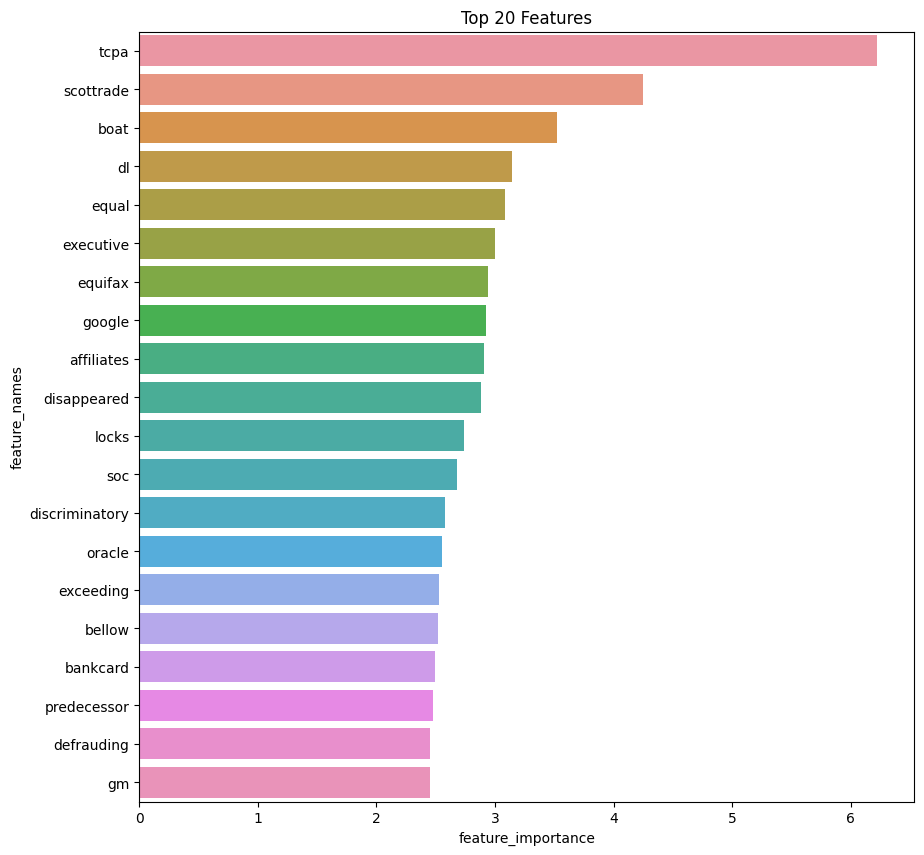

In [53]:
df_feature_importance = df_feature_importance.sort_values(by='feature_importance', ascending=False)

# plot top 20 features

plt.figure(figsize=(10, 10))
sns.barplot(x='feature_importance', y='feature_names', data=df_feature_importance.head(20))
plt.title('Top 20 Features')
plt.show()


Naive Bayes tfidf: 0.735

In [55]:

# since naive bayes doesn't work with negative values, we scale the values

scaler = MaxAbsScaler()
model_lr = train_lr(scaler.fit_transform(X_smote_train), y_smote_train, scaler.transform(X_smote_test), y_smote_test)



f1 score: 0.734605295438676


CatBoostClassifier tfidf: 0.794

In [56]:
# train with catboost
model_catboost = train_catboost(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

Learning rate set to 0.100046
0:	learn: 0.6757410	total: 1.07s	remaining: 17m 50s
1:	learn: 0.6601302	total: 2.05s	remaining: 17m 3s
2:	learn: 0.6449992	total: 3.02s	remaining: 16m 43s
3:	learn: 0.6337022	total: 3.95s	remaining: 16m 24s
4:	learn: 0.6222814	total: 4.92s	remaining: 16m 20s
5:	learn: 0.6124706	total: 5.83s	remaining: 16m 6s
6:	learn: 0.6047401	total: 6.7s	remaining: 15m 49s
7:	learn: 0.5980568	total: 7.58s	remaining: 15m 40s
8:	learn: 0.5903439	total: 8.49s	remaining: 15m 34s
9:	learn: 0.5841083	total: 9.39s	remaining: 15m 29s
10:	learn: 0.5773165	total: 10.3s	remaining: 15m 25s
11:	learn: 0.5724892	total: 11.2s	remaining: 15m 18s
12:	learn: 0.5669780	total: 12.1s	remaining: 15m 16s
13:	learn: 0.5629218	total: 13s	remaining: 15m 14s
14:	learn: 0.5591755	total: 13.9s	remaining: 15m 12s
15:	learn: 0.5566081	total: 14.8s	remaining: 15m 7s
16:	learn: 0.5531827	total: 15.6s	remaining: 15m 4s
17:	learn: 0.5507534	total: 16.5s	remaining: 15m 1s
18:	learn: 0.5478491	total: 17.4s	

LGBMClassifier tfidf 0.777 (very fast)

In [58]:

# train with lgbm
model_lgbm = train_lgbm(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

[LightGBM] [Info] Number of positive: 102582, number of negative: 102581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 16.314267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1192906
[LightGBM] [Info] Number of data points in the train set: 205163, number of used features: 14304
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000010
[LightGBM] [Info] Start training from score 0.000010
f1 score: 0.7745418135910496


KNeighborsClassifier tfidf 0.681

In [109]:
# knnclassifier with tfidf data, wrap in a function

def train_knn(X_train, y_train, X_test, y_test):

    # instantiate knn model
    knn = KNeighborsClassifier(random_state=42)

    # fit model
    knn.fit(X_train, y_train)

    # predict on test set
    y_pred = knn.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred)}")

    return knn


f1 score: 0.6805433245269928


In [ ]:

# train with knn
model_knn = train_knn(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

question (full narrative data)

bench test: lr and nb model f1

- bow only (below)

- tfidf only (done. above section)
- tfidf only. feature importantces, key terms (done)

- w2v only (done)

- tfidf weighted w2v, which better? (done. non-weighted w2v is better than tfidf weighed w2v)

to test. w2v (or tfidf-w2v) mixture with other categorical columns? (done, tfidf-w2v mixture categorical perform best)

#### BOW only

In [31]:
# BOW on narrative_processed column

# initialize count vectorizer
count_vectorizer = CountVectorizer()

# fit and transform count vectorizer on narrative_processed column
count_vectorizer.fit(df2.narrative_processed)
count_vectorizer_matrix = count_vectorizer.transform(df2.narrative_processed)

# print shape of count_vectorizer_matrix
print(f"shape of count_vectorizer_matrix: {count_vectorizer_matrix.shape}")


shape of count_vectorizer_matrix: (164034, 94466)


In [32]:
# smote to oversample minority class for count vectorizer data
smote = SMOTE(random_state=42)
X_smote_bow, y_smote_bow = smote.fit_resample(count_vectorizer_matrix, df2.disputed)

# print shape of X_smote_bow, y_smote_bow
print(X_smote_bow.shape, y_smote_bow.shape)

(256454, 94466) (256454,)


In [33]:
# train test split, 20% test, random_state=42, stratify=y_smote_bow
X_smote_bow_train, X_smote_bow_test, y_smote_bow_train, y_smote_bow_test = train_test_split(X_smote_bow, y_smote_bow, stratify=y_smote_bow, random_state=42, test_size=0.2)

# print shape of X_smote_bow_train, X_smote_bow_test, y_smote_bow_train, y_smote_bow_test
print(X_smote_bow_train.shape, X_smote_bow_test.shape, y_smote_bow_train.shape, y_smote_bow_test.shape)

(205163, 94466) (51291, 94466) (205163,) (51291,)


logistic regression: 0.763

In [34]:
# train BOW with logistic regression
model_lr_bow = train_lr(X_smote_bow_train, y_smote_bow_train, X_smote_bow_test, y_smote_bow_test)

f1 score: 0.7628121736262529


naive_bayes: 0.721

In [37]:
# train BOW with naive bayes

model_nb_bow = train_naive_bayes(X_smote_bow_train, y_smote_bow_train, X_smote_bow_test, y_smote_bow_test)

f1 score: 0.7211319203020448


In [46]:
# train lightgbm with BOW data

def train_lgbm_bow(X_train, y_train, X_test, y_test):
    # Convert input features to float32
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    # Instantiate LightGBM model
    lgbm = LGBMClassifier(random_state=42)
    
    # Fit model
    lgbm.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = lgbm.predict(X_test)
    
    # Calculate and print f1 score
    f1 = f1_score(y_test, y_pred)
    print(f"f1 score: {f1}")
    
    return lgbm


[LightGBM] [Info] Number of positive: 102582, number of negative: 102581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.422180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50299
[LightGBM] [Info] Number of data points in the train set: 205163, number of used features: 10428
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000010
[LightGBM] [Info] Start training from score 0.000010
f1 score: 0.7518208413194796


In [ ]:

model_lgbm_bow = train_lgbm_bow(X_smote_bow_train, y_smote_bow_train, X_smote_bow_test, y_smote_bow_test)

#### W2V only

In [49]:
# get w2v vector for each narrative, reuse function from above

df2['narrative_w2v'] = df2['narrative_processed'].progress_apply(get_mean_word2vec)

100%|██████████| 164034/164034 [00:43<00:00, 3758.45it/s]


In [51]:
# subset narrative_w2v column and disupted column to df_w2v
df_w2v = df2[['narrative_w2v', 'disputed']]

# print shape of df_w2v
print(df_w2v.shape)

# print number of null values in df_w2v
print(df_w2v.isnull().sum())


(164034, 2)
narrative_w2v    0
disputed         0
dtype: int64


In [52]:
# convert df_w2v['narrative_w2v']  to numpy array X_w2v

X_w2v = np.array(df_w2v.narrative_w2v.tolist())

y = df_w2v.disputed.copy()

In [53]:
# apply smote to oversample minority class

smote = SMOTE(random_state=42)
X_w2v_smote, y_w2v_smote = smote.fit_resample(X_w2v, y)

# print shape of X_w2v_smote, y_w2v_smote
print(X_w2v_smote.shape, y_w2v_smote.shape)

(256454, 300) (256454,)


In [55]:
# train test split, 20% test, random_state=42, stratify=y_w2v_smote
X_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_train, y_w2v_smote_test = train_test_split(X_w2v_smote, y_w2v_smote, stratify=y_w2v_smote, random_state=42, test_size=0.2)

LogisticRegression: 0.594

In [56]:
# train lr

model_lr_w2v = train_lr(X_w2v_smote_train, y_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_test)

f1 score: 0.5937518157695958


naive bayes: 0.595

In [58]:
# train naive bayes

scaler = MaxAbsScaler()
model_lr_w2v = train_lr(scaler.fit_transform(X_w2v_smote_train), y_w2v_smote_train, scaler.transform(X_w2v_smote_test), y_w2v_smote_test)



f1 score: 0.5949083030256131


lightgbm: 0.689

In [59]:
# train lightgbm with w2v data

model_lgbm_w2v = train_lgbm(X_w2v_smote_train, y_w2v_smote_train, X_w2v_smote_test, y_w2v_smote_test)

[LightGBM] [Info] Number of positive: 102582, number of negative: 102581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 205163, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000010
[LightGBM] [Info] Start training from score 0.000010
f1 score: 0.6891626208722866


#### TFIDF-W2V (tw)

In [60]:
dftw = data.copy()

# rename columns

dftw

,narrative,disputed
31338,"XXXX XXXX, 2016 To Whom It May Concern : I am ...",Yes
31664,History of account : I am a co-signer on XXXX ...,Yes
35599,I have excellent credit and the only times I m...,Yes
49963,There are XXXX hard pulls in my credit reports...,No
70552,Experian has fail to delete wrong personal inf...,No
...,...,...
4024109,I opened a checking account in XX/XX/XXXX with...,Yes
4024112,There was an overpayment on my credit card of ...,No
4024119,I have filed dispute to Credit bureau but they...,No
4024126,This complaint follows practices performed by ...,No


In [61]:
# encode disputed column and preprocess narrative column

dftw.disputed = dftw.disputed.map({'No': 0, 'Yes': 1})

dftw['narrative_processed'] = dftw.narrative.progress_apply(preprocess_narrative)

100%|██████████| 164034/164034 [00:15<00:00, 10385.93it/s]


In [63]:
# get tfidf weighted word2vec vector for each narrative, reuse function from above

dftw['narrative_tw'] = dftw['narrative_processed'].progress_apply(get_mean_tfidf_weighted_word2vec)

100%|██████████| 164034/164034 [1:07:47<00:00, 40.33it/s]


In [66]:
# convert df_tw['narrative_tw']  to numpy array X_tw, assign y to disputed column

X_tw = np.array(dftw.narrative_tw.tolist())
y = dftw.disputed.copy()

# smote to oversample minority class
smote = SMOTE(random_state=42)
X_tw_smote, y_tw_smote = smote.fit_resample(X_tw, y)
print(X_tw_smote.shape, y_tw_smote.shape)


(256454, 300) (256454,)


In [67]:
# train test split, 20% test, random_state=42, stratify=y_tw_smote
X_tw_smote_train, X_tw_smote_test, y_tw_smote_train, y_tw_smote_test = train_test_split(X_tw_smote, y_tw_smote, stratify=y_tw_smote, random_state=42, test_size=0.2)

LogisticRegression: 0.589



Naive Bayes: 0.589

In [68]:
# train lr and naive bayes
model_lr_tw = train_lr(X_tw_smote_train, y_tw_smote_train, X_tw_smote_test, y_tw_smote_test)

# since naive bayes doesn't work with negative values, we scale the values

scaler = MaxAbsScaler()
model_lr_tw = train_lr(scaler.fit_transform(X_tw_smote_train), y_tw_smote_train, scaler.transform(X_tw_smote_test), y_tw_smote_test)

f1 score: 0.5894106280193236
f1 score: 0.5892674254574968


lightgbm: 0.684

In [69]:
# train lightgbm with tfidf weighted word2vec data
model_lgbm_tw = train_lgbm(X_tw_smote_train, y_tw_smote_train, X_tw_smote_test, y_tw_smote_test)

[LightGBM] [Info] Number of positive: 102582, number of negative: 102581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 205163, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000010
[LightGBM] [Info] Start training from score 0.000010
f1 score: 0.6840841574085378


#### Experiment. Mixture of categorical columns and w2v matrix

In [74]:
df = DATA.copy()

# rename columns
df.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-08-23,"Payday loan, title loan, or personal loan",Installment loan,Problem when making payments,NaN,NaN,NaN,OneMain Finance Corporation,NC,27407,NaN,NaN,Web,2023-08-23,Closed with explanation,Yes,NaN,7448359
1,2023-08-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,GA,30318,NaN,Consent not provided,Web,2023-08-23,Closed with non-monetary relief,Yes,NaN,7442747


In [77]:
# drop missing values in disputed column and narrative column
df.dropna(subset=['Consumer disputed?', 'Consumer complaint narrative'], inplace=True)

In [79]:
# drop ZIP code column and Complaint ID column, Consumer consent provided? column, Submitted via Column
df.drop(['ZIP code', 'Complaint ID', 'Consumer consent provided?', 'Submitted via'], axis=1, inplace=True)


In [87]:
# compute date sent - date received, convery them to datetime format for substraction. store in column 'days' as int

df['Date received'] = pd.to_datetime(df['Date received'])
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'])

df['days'] = (df['Date sent to company'] - df['Date received']).dt.days

# drop Date received and Date sent to company columns
df.drop(['Date received', 'Date sent to company'], axis=1, inplace=True)


In [89]:
df['Timely response?'].value_counts()

Yes    157932
No       6102
Name: Timely response?, dtype: int64

In [92]:
# disputed yes, how many timely response? in ratio

df[df['Consumer disputed?'] == 'Yes']['Timely response?'].value_counts(normalize=True)

Yes    0.977602
No     0.022398
Name: Timely response?, dtype: float64

In [93]:
# disputed no, how many timely response? in ratio

df[df['Consumer disputed?'] == 'No']['Timely response?'].value_counts(normalize=True)

Yes    0.958667
No     0.041333
Name: Timely response?, dtype: float64

In [94]:
# drop Timely response? column

df.drop('Timely response?', axis=1, inplace=True)

In [97]:
# check missing values across columns

df.isnull().sum()

Product                              0
Sub-product                      52171
Issue                                0
Sub-issue                        80979
Consumer complaint narrative         0
Company public response          85912
Company                              0
State                              459
Tags                            137040
Company response to consumer         0
Consumer disputed?                   0
days                                 0
dtype: int64

In [98]:
# fill missing values with 'Unknown' in all columns
df.fillna('Unknown', inplace=True)

# check missing values across columns
df.isnull().sum()

Product                         0
Sub-product                     0
Issue                           0
Sub-issue                       0
Consumer complaint narrative    0
Company public response         0
Company                         0
State                           0
Tags                            0
Company response to consumer    0
Consumer disputed?              0
days                            0
dtype: int64

In [99]:
# preprocess narrative column and store in narrative_processed column

df['narrative_processed'] = df['Consumer complaint narrative'].progress_apply(preprocess_narrative)



100%|██████████| 164034/164034 [00:16<00:00, 10054.65it/s]


In [100]:
# apply word2vec on narrative_processed column, save to narrative_w2v column
df['narrative_w2v'] = df['narrative_processed'].progress_apply(get_mean_word2vec)

100%|██████████| 164034/164034 [00:35<00:00, 4612.34it/s]


In [103]:
df.columns

Index(['Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'Tags', 'Company response to consumer', 'Consumer disputed?',
       'days', 'narrative_processed', 'narrative_w2v'],
      dtype='object')

In [105]:
y = df['Consumer disputed?'].copy()

narrative_w2v_matrix = np.array(df.narrative_w2v.tolist())

narrative_processed_matrix = np.array(df.narrative_processed.tolist())

narrative_original_matrix = np.array(df['Consumer complaint narrative'].tolist())

KeyError: "['narraive_processed'] not found in axis"

In [107]:
narrative_processed_matrix

array(['may concern writing regard barrett financial llc dealing company feel important pertinent agencies notified shady business practices every hard money lender az said illegal owner occupied home hoping letter writing get someone look company ability follow understand law really hurt someone information terrified capable hoping put fraud alert credit agencies everyone involved deal unhappy company worked particular man show respect told blatant lies another party process purchasing home took personal financial info including bank account info social security numbers sent us prequalification letter found home put offer following guidelines thought good wrong man disappeared buyers sellers agent agent title company inspection company hold talked receptionist know going would circumstances allow us speak another lender phone message machines voice mails full front main line went days lost house asked simply pay us back wire transfer costs title company refused still refuses day knew 

In [108]:
narrative_original_matrix

array(["XXXX XXXX, 2016 To Whom It May Concern : I am writing in regard to Barrett Financial L.L.C. After dealing with this company, I feel it is very important that all pertinent agencies are notified about their shady business practices. Every other hard money lender in AZ said what he was doing was 100 % illegal for an owner occupied home. I am hoping my letter writing will get someone to look into this company and their ability to follow and understand the law, before they really hurt someone. With all the information they have on me I am terrified of what they are capable of doing to me. I am hoping to put a fraud alert on with all the credit agencies for everyone involved in the deal. \nI was very unhappy with this company! I worked with XXXX XXXX. This particular man did not show me respect. He told blatant lies. Another party and I were in the process of purchasing a home with XXXX. He took all our personal financial info ( including bank account info and social security number

In [109]:
narrative_w2v_matrix

array([[ 4.03310955e-02,  2.66198311e-02,  1.48412865e-02, ...,
        -5.60802110e-02,  7.92303402e-03, -4.32446934e-02],
       [ 1.53348176e-02,  4.56538722e-02,  2.79140938e-02, ...,
        -2.97490135e-02,  1.41884778e-02, -3.53953280e-02],
       [ 1.57127827e-02,  3.29174884e-02,  1.58946514e-02, ...,
        -5.23409769e-02,  6.34420989e-03, -4.40079980e-02],
       ...,
       [-7.43408203e-02,  4.70648892e-03,  5.74408658e-03, ...,
        -9.64355469e-02, -1.33680552e-01,  3.20095494e-02],
       [-3.67872952e-03,  4.22935337e-02,  2.65742876e-02, ...,
        -6.74242377e-02, -1.14557631e-02, -3.84237207e-02],
       [ 3.22739870e-05,  2.30683796e-02,  2.35056151e-02, ...,
        -7.92681053e-02, -2.23291526e-03, -6.01284802e-02]])

In [111]:
# drop Consumer complaint narrative, narrative_processed, narrative_w2v, Consumer disputed? columns
df.drop(['Consumer complaint narrative', 'narrative_processed', 'narrative_w2v', 'Consumer disputed?'], axis=1, inplace=True)

# check shape of df
df.columns

Index(['Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Company public response', 'Company', 'State', 'Tags',
       'Company response to consumer', 'days'],
      dtype='object')

In [112]:
df.nunique()

Product                           12
Sub-product                       47
Issue                             91
Sub-issue                         58
Company public response           11
Company                         3148
State                             63
Tags                               4
Company response to consumer       5
days                             269
dtype: int64

In [114]:
# categorical columns Product                         

cat_cols = [
    "Product",
    "Sub-product",
    "Issue",
    "Sub-issue",
    "Company public response",
    "Company",
    "State",
    "Tags",
    "Company response to consumer"
]



In [116]:
# one hot encode categorical columns
df = pd.get_dummies(df, columns=cat_cols)

# check shape of df
df.shape

(164034, 3440)

In [117]:
df.columns

Index(['days', 'Product_Bank account or service', 'Product_Consumer Loan',
       'Product_Credit card', 'Product_Credit reporting',
       'Product_Debt collection', 'Product_Money transfers',
       'Product_Mortgage', 'Product_Other financial service',
       'Product_Payday loan',
       ...
       'State_WY', 'Tags_Older American', 'Tags_Older American, Servicemember',
       'Tags_Servicemember', 'Tags_Unknown',
       'Company response to consumer_Closed',
       'Company response to consumer_Closed with explanation',
       'Company response to consumer_Closed with monetary relief',
       'Company response to consumer_Closed with non-monetary relief',
       'Company response to consumer_Untimely response'],
      dtype='object', length=3440)

In [119]:
# concatenate narrative_w2v_matrix with df
X = np.concatenate((narrative_w2v_matrix, df), axis=1)

# check shape of X
X.shape

(164034, 3740)

In [122]:
# convert back to dataframe
df = pd.DataFrame(X, columns=list(range(X.shape[1])))

# check shape of df
df.shape

(164034, 3740)

In [123]:
df

,0,1,2,3,4,5,6,7,8,9,...,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739
0,0.040331,0.026620,0.014841,0.014846,-0.043637,0.000967,0.057010,-0.029973,0.068532,0.010967,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.015335,0.045654,0.027914,0.039537,-0.039236,-0.039606,0.051731,-0.051289,0.112583,0.051383,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.015713,0.032917,0.015895,0.039849,-0.040777,-0.038908,0.052282,-0.054552,0.101980,0.038749,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-0.009928,0.047897,-0.017245,0.025085,0.007024,0.019206,0.031511,-0.071070,0.180567,-0.099528,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-0.005290,-0.038241,0.093601,0.012044,-0.105635,0.013963,0.062344,-0.002190,0.142828,0.001794,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164029,-0.020167,-0.007511,0.017210,-0.032641,-0.034213,0.006221,0.050488,-0.022190,0.127320,0.025251,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
164030,-0.079239,0.061995,0.037255,0.066190,0.020204,-0.029269,0.014772,-0.048678,0.078075,-0.017703,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
164031,-0.074341,0.004706,0.005744,-0.151923,0.049004,-0.062514,0.132853,-0.049582,0.063992,-0.006917,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
164032,-0.003679,0.042294,0.026574,0.042956,-0.058771,-0.022558,0.064927,-0.032685,0.113615,0.030233,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [127]:
# check 301th column

df[300]

0         61.0
1          2.0
2          0.0
3          0.0
4          0.0
          ... 
164029     0.0
164030     0.0
164031     0.0
164032     0.0
164033     0.0
Name: 300, Length: 164034, dtype: float64

In [128]:
# smote to oversample minority class
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df, y)

# print shape of X_smote, y_smote
print(X_smote.shape, y_smote.shape)

# print value counts of y_smote
print(pd.Series(y_smote).value_counts())


(256454, 3740) (256454,)
Yes    128227
No     128227
Name: Consumer disputed?, dtype: int64


In [134]:
# encode y_smote to 0 and 1
y_smote = y_smote.map({'No': 0, 'Yes': 1})


In [135]:
# train test split, 20% test, random_state=42, stratify=y_smote
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, stratify=y_smote, random_state=42, test_size=0.2)

# print shape
print(X_smote_train.shape, X_smote_test.shape, y_smote_train.shape, y_smote_test.shape)

# print value counts of y_smote_train
print(pd.Series(y_smote_train).value_counts())

(205163, 3740) (51291, 3740) (205163,) (51291,)
1    102582
0    102581
Name: Consumer disputed?, dtype: int64


xgboost: 0.792

In [141]:
# train with xgboost
model_xgb = train_xgb(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

[15:26:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.7924859264093987


Lightgbm: 0.781

In [136]:
# train with lightgbm
model_lgbm_w2v_onehot = train_lgbm(X_smote_train, y_smote_train, X_smote_test, y_smote_test)


[LightGBM] [Info] Number of positive: 102582, number of negative: 102581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.889060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129863
[LightGBM] [Info] Number of data points in the train set: 205163, number of used features: 1376
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000010
[LightGBM] [Info] Start training from score 0.000010
f1 score: 0.7811456298443505


CatBoost: 0.814

In [137]:
# train with catboost
model_catboost_w2v_onehot = train_catboost(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

Learning rate set to 0.100046
0:	learn: 0.6812282	total: 151ms	remaining: 2m 30s
1:	learn: 0.6745768	total: 231ms	remaining: 1m 55s
2:	learn: 0.6684506	total: 306ms	remaining: 1m 41s
3:	learn: 0.6634391	total: 384ms	remaining: 1m 35s
4:	learn: 0.6587479	total: 466ms	remaining: 1m 32s
5:	learn: 0.6523111	total: 542ms	remaining: 1m 29s
6:	learn: 0.6487270	total: 618ms	remaining: 1m 27s
7:	learn: 0.6454409	total: 698ms	remaining: 1m 26s
8:	learn: 0.6425357	total: 773ms	remaining: 1m 25s
9:	learn: 0.6398729	total: 855ms	remaining: 1m 24s
10:	learn: 0.6312922	total: 935ms	remaining: 1m 24s
11:	learn: 0.6203893	total: 1.01s	remaining: 1m 23s
12:	learn: 0.6180025	total: 1.09s	remaining: 1m 23s
13:	learn: 0.6139492	total: 1.18s	remaining: 1m 23s
14:	learn: 0.6121039	total: 1.26s	remaining: 1m 22s
15:	learn: 0.6102919	total: 1.34s	remaining: 1m 22s
16:	learn: 0.6087215	total: 1.43s	remaining: 1m 22s
17:	learn: 0.6070896	total: 1.5s	remaining: 1m 22s
18:	learn: 0.6028153	total: 1.58s	remaining: 

#### Experiment. Mixture of categorical columns and TFIDF w2v matrix 

In [68]:
dfm = DATA.copy()

In [69]:
# drop na on Consumer complaint narrative column, Consumer disputed? column

dfm.dropna(subset=['Consumer complaint narrative', 'Consumer disputed?'], inplace=True)

In [26]:
# drop Tags, ZIP code, Complaint ID, Timely response? columns

dfm.drop(['ZIP code', 'Complaint ID', 'Timely response?'], axis=1, inplace=True)

In [27]:
# dfm unique values

dfm.nunique()

Date received                      766
Product                             12
Sub-product                         46
Issue                               91
Sub-issue                           57
Consumer complaint narrative    160940
Company public response             10
Company                           3148
State                               62
Tags                                 3
Consumer consent provided?           1
Submitted via                        1
Date sent to company               862
Company response to consumer         5
Consumer disputed?                   2
dtype: int64

In [28]:
# drop Consumer consent provided? column, submitted via column. no variance. 

dfm.drop(['Consumer consent provided?', 'Submitted via'], axis=1, inplace=True)

dfm.nunique()

Date received                      766
Product                             12
Sub-product                         46
Issue                               91
Sub-issue                           57
Consumer complaint narrative    160940
Company public response             10
Company                           3148
State                               62
Tags                                 3
Date sent to company               862
Company response to consumer         5
Consumer disputed?                   2
dtype: int64

In [29]:
# convert date received and date sent to company to datetime format, and compute date sent - date received, store in column 'days' as int

dfm['Date received'] = pd.to_datetime(dfm['Date received'])
dfm['Date sent to company'] = pd.to_datetime(dfm['Date sent to company'])

dfm['days'] = (dfm['Date sent to company'] - dfm['Date received']).dt.days

# drop Date received and Date sent to company columns
dfm.drop(['Date received', 'Date sent to company'], axis=1, inplace=True)
dfm.nunique()

Product                             12
Sub-product                         46
Issue                               91
Sub-issue                           57
Consumer complaint narrative    160940
Company public response             10
Company                           3148
State                               62
Tags                                 3
Company response to consumer         5
Consumer disputed?                   2
days                               269
dtype: int64

In [30]:
# fill na with 'Unknown' in all columns

dfm.fillna('Unknown', inplace=True)

dfm.isna().sum()

Product                         0
Sub-product                     0
Issue                           0
Sub-issue                       0
Consumer complaint narrative    0
Company public response         0
Company                         0
State                           0
Tags                            0
Company response to consumer    0
Consumer disputed?              0
days                            0
dtype: int64

In [31]:
# encode disputed column to 0 and 1

dfm['Consumer disputed?'] = dfm['Consumer disputed?'].map({'No': 0, 'Yes': 1})

dfm['Consumer disputed?'].value_counts()

0    128227
1     35807
Name: Consumer disputed?, dtype: int64

In [32]:
# preprocess narrative column and store in narrative_processed column

dfm['narrative_processed'] = dfm['Consumer complaint narrative'].progress_apply(preprocess_narrative)

  0%|          | 0/164034 [00:00<?, ?it/s]

100%|██████████| 164034/164034 [00:17<00:00, 9620.37it/s] 


In [36]:


tfidf = TfidfVectorizer()

# fit and transform tfidf vectorizer on narrative_processed column
tfidf.fit(dfm.narrative_processed)

# get tfidf feature names
tfidf_features = tfidf.get_feature_names()

# get tfidf weights
tfidf_weights = tfidf.idf_


In [37]:

# compute mean tfidf weighted word2vec vector for each narrative, reuse function from above
dfm['narrative_tw'] = dfm['narrative_processed'].progress_apply(get_mean_tfidf_weighted_word2vec)

# convert dfm['narrative_tw']  to numpy array tw_array
tw_array = np.array(dfm.narrative_tw.tolist())

# print shape of tw_array
tw_array.shape

100%|██████████| 164034/164034 [1:10:02<00:00, 39.04it/s]


(164034, 300)

In [39]:
dfm.columns

Index(['Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'Tags', 'Company response to consumer', 'Consumer disputed?',
       'days', 'narrative_processed', 'narrative_tw'],
      dtype='object')

In [20]:
# copy target column to y
y = dfm['Consumer disputed?'].copy()

In [42]:
# drop Consumer complaint narrative, narrative_processed, Consumer disputed? columns

dfm.drop(['Consumer complaint narrative', 'narrative_processed', 'narrative_tw', 'Consumer disputed?'], axis=1, inplace=True)


In [43]:
dfm.nunique()

Product                           12
Sub-product                       47
Issue                             91
Sub-issue                         58
Company public response           11
Company                         3148
State                             63
Tags                               4
Company response to consumer       5
days                             269
dtype: int64

In [44]:
# one hot encode categorical columns, reuse cat_cols from above

cats_cols = [
    'Product', 
    'Sub-product', 
    'Issue', 
    'Sub-issue',
    'Company public response', 
    'Company',
    'State', 
    'Tags', 
    'Company response to consumer',
]


dfm = pd.get_dummies(dfm, columns=cats_cols)

print(dfm.columns)

print(dfm.shape)

Index(['days', 'Product_Bank account or service', 'Product_Consumer Loan',
       'Product_Credit card', 'Product_Credit reporting',
       'Product_Debt collection', 'Product_Money transfers',
       'Product_Mortgage', 'Product_Other financial service',
       'Product_Payday loan',
       ...
       'State_WY', 'Tags_Older American', 'Tags_Older American, Servicemember',
       'Tags_Servicemember', 'Tags_Unknown',
       'Company response to consumer_Closed',
       'Company response to consumer_Closed with explanation',
       'Company response to consumer_Closed with monetary relief',
       'Company response to consumer_Closed with non-monetary relief',
       'Company response to consumer_Untimely response'],
      dtype='object', length=3440)
(164034, 3440)


In [45]:
# concatenate tw_array with dfm
X = np.concatenate((tw_array, dfm), axis=1)

# check shape of X
X.shape

(164034, 3740)

In [46]:
# smoote to oversample minority class
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# print shape of X_smote, y_smote
print(X_smote.shape, y_smote.shape)

(256454, 3740) (256454,)


In [47]:
# train test split, 20% test, random_state=42, stratify=y_smote

X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, stratify=y_smote, random_state=42, test_size=0.2)

# print shape

print(X_smote_train.shape, X_smote_test.shape, y_smote_train.shape, y_smote_test.shape)

(205163, 3740) (51291, 3740) (205163,) (51291,)


0.801

In [52]:
# train lightgbm with tfidf weighted word2vec data

model_lgbm_tw_onehot = train_lgbm(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

[LightGBM] [Info] Number of positive: 102582, number of negative: 102581
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.913143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 138688
[LightGBM] [Info] Number of data points in the train set: 205163, number of used features: 1395
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000010
[LightGBM] [Info] Start training from score 0.000010
f1 score: 0.8006513541309566


catboost mixture categorical with tdidf w2v: f1 0.823 (BEST SO FAR)

In [ ]:
# train catboost with tfidf weighted word2vec data

model_catboost_tw_onehot = train_catboost(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

In [56]:
# train with naive bayes, scale values

min_max_scaler = MinMaxScaler()

model_nb_tw_onehot = train_naive_bayes(min_max_scaler.fit_transform(X_smote_train), y_smote_train, min_max_scaler.transform(X_smote_test), y_smote_test)


f1 score: 0.6275768147305189


In [59]:
# train with logistic regression

model_lr_tw_onehot = train_lr(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

f1 score: 0.6619451260316753


In [63]:
# define function to train ann with tfidf weighted word2vec data

def train_ann_tw_onehot(X_train, y_train, X_test, y_test):

    # instantiate ann model
    ann = Sequential()

    # add input layer
    ann.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

    # add hidden layers
    ann.add(Dense(64, activation='relu'))
    ann.add(Dense(32, activation='relu'))
    ann.add(Dense(16, activation='relu'))

    # add output layer
    ann.add(Dense(1, activation='sigmoid'))

    # compile model
    ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # fit model
    ann.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    # predict on test set
    y_pred = ann.predict(X_test)

    # print f1 score
    print(f"f1 score: {f1_score(y_test, y_pred.round())}")

    return ann


In [64]:
# train with ann

model_ann_tw_onehot = train_ann_tw_onehot(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

Epoch 1/10
6412/6412 [==============================] - 36s 6ms/step - loss: 0.6138 - accuracy: 0.6618 - val_loss: 0.5767 - val_accuracy: 0.7014
Epoch 2/10
6412/6412 [==============================] - 37s 6ms/step - loss: 0.5469 - accuracy: 0.7236 - val_loss: 0.5510 - val_accuracy: 0.7182
Epoch 3/10
6412/6412 [==============================] - 37s 6ms/step - loss: 0.4997 - accuracy: 0.7579 - val_loss: 0.5347 - val_accuracy: 0.7322
Epoch 4/10
6412/6412 [==============================] - 37s 6ms/step - loss: 0.4608 - accuracy: 0.7832 - val_loss: 0.5046 - val_accuracy: 0.7590
Epoch 5/10
6412/6412 [==============================] - 38s 6ms/step - loss: 0.4279 - accuracy: 0.8020 - val_loss: 0.4932 - val_accuracy: 0.7681
Epoch 6/10
6412/6412 [==============================] - 40s 6ms/step - loss: 0.4024 - accuracy: 0.8166 - val_loss: 0.4933 - val_accuracy: 0.7730
Epoch 7/10
6412/6412 [==============================] - 40s 6ms/step - loss: 0.3807 - accuracy: 0.8278 - val_loss: 0.4932 - val_ac

xgb 0.812

In [66]:
# train with xgboost

model_xgb_tw_onehot = train_xgb(X_smote_train, y_smote_train, X_smote_test, y_smote_test)

[15:53:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.811506402891224


hypothsis: remove company. 3400+ instance to expand columns. added noise? (no, it added information. tested)